### NO2 emission and COVID Lockdown effects

The COVID-19 pandemic has had a significant effect on reducing both human and industrial activities, leading to certain positive outcomes such as a decrease in air pollutants, as discussed in this [paper](https://ieeexplore.ieee.org/abstract/document/9617331). 

Therefore, in this notebook, we aim to explore the trend in air pollution, focusing on the NO2 product of the Sentinel 5P collection. We will simply, compare the situation during and after the onset of COVID-19 lockdown in the Delhi region of India.

Further information on Sentinel-5P can be found the following links:

* https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel5P.html
* https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-5P/Sentinel-5P_brings_air_pollution_into_focus


In [2]:
import openeo

In [3]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


### 1. Create a datacube for period during COVID lockdowns

In [8]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [77.11, 28.69],
            [77.11, 28.56],
            [77.29, 28.56],
            [77.29, 28.69],
            [77.11, 28.69],
        ]
    ],
}

In [9]:
s5covid = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2020-06-01", "2021-06-30"],
    spatial_extent={"west": 77.11, "south": 28.56, "east": 77.29, "north": 28.69},
    bands=["NO2"],
)

In [10]:
# Now aggregate by day to avoid having multiple data per day
s5covid = s5covid.aggregate_temporal_period(reducer="mean", period="day")

# let's create a spatial aggregation to generate mean timeseries data
s5covid = s5covid.aggregate_spatial(reducer="mean", geometries=aoi)

### 2. Let's repeat the same process for Post Covid Situation

In [11]:
# Create a datacube for period after COVID lockdowns

s5post = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2022-06-01", "2023-06-30"],
    spatial_extent={"west": 77.11, "south": 28.56, "east": 77.29, "north": 28.69},
    bands=["NO2"],
)

# Now aggregate by day to avoid having multiple data per day
s5post = s5post.aggregate_temporal_period(reducer="mean", period="day")

# Now create a spatial aggregation to generate mean timeseries data
s5post = s5post.aggregate_spatial(reducer="mean", geometries=aoi)

Finally we execute them as batch jobs and download the results as netCDF. They are further plotted as shown below to study the data.

In [14]:
job = s5covid.execute_batch(title="NO2 during Covid", outputfile="during_covid.nc")

0:00:00 Job 'j-240115e1f4dc4beea1c133d6498ee198': send 'start'
0:02:06 Job 'j-240115e1f4dc4beea1c133d6498ee198': running (progress N/A)
0:02:12 Job 'j-240115e1f4dc4beea1c133d6498ee198': running (progress N/A)
0:02:18 Job 'j-240115e1f4dc4beea1c133d6498ee198': running (progress N/A)
0:04:08 Job 'j-240115e1f4dc4beea1c133d6498ee198': running (progress N/A)
0:04:18 Job 'j-240115e1f4dc4beea1c133d6498ee198': running (progress N/A)
0:06:00 Job 'j-240115e1f4dc4beea1c133d6498ee198': running (progress N/A)
0:09:46 Job 'j-240115e1f4dc4beea1c133d6498ee198': finished (progress N/A)


In [15]:
job = s5post.execute_batch(title="NO2 Post-Covid", outputfile="post_covid.nc")

0:00:00 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': send 'start'
0:01:55 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': created (progress N/A)
0:02:01 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': created (progress N/A)
0:03:30 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': running (progress N/A)
0:03:48 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': running (progress N/A)
0:03:58 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': running (progress N/A)
0:04:11 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': running (progress N/A)
0:04:26 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': running (progress N/A)
0:04:45 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': running (progress N/A)
0:05:19 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': running (progress N/A)
0:05:49 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': running (progress N/A)
0:07:54 Job 'j-240115fb53df44bea28bb7e8dcc1e4cd': finished (progress N/A)


### Let's plot the result

In [16]:
import xarray as xr
import matplotlib.pyplot as plt

In [17]:
# load the results
duringdata = xr.load_dataset("during_covid.nc")
postdata = xr.load_dataset("post_covid.nc")

Let's calculate the mean along-time dimension for the window size of 30days.

In [18]:
duringdata = duringdata.rolling(t=30).mean()
postdata = postdata.rolling(t=30).mean()

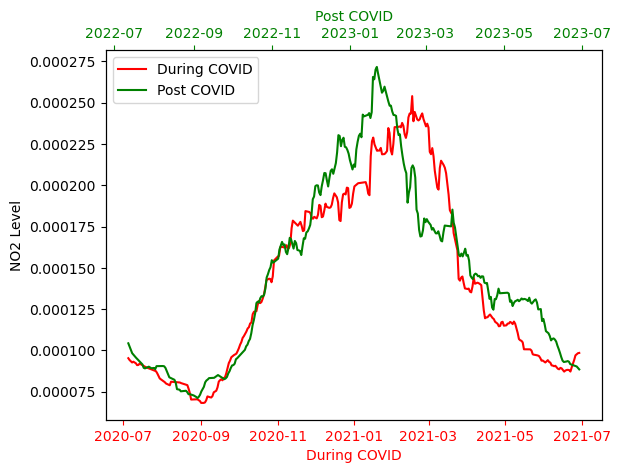

In [19]:
fig, ax1 = plt.subplots(dpi=100)
(line1,) = ax1.plot(
    duringdata.t, duringdata.NO2.to_numpy().flatten(), color="r", label="During COVID"
)
ax1.set_xlabel("During COVID")
ax1.set_ylabel("NO2 Level")
ax1.xaxis.label.set_color("r")
ax1.tick_params(axis="x", colors="r")

ax2 = ax1.twiny()
(line2,) = ax2.plot(
    postdata.t, postdata.NO2.to_numpy().flatten(), color="g", label="Post COVID"
)
ax2.set_xlabel("Post COVID")
# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")
ax2.xaxis.label.set_color("g")
ax2.tick_params(axis="x", colors="g")

The red line in the plot shows the NO2 concentration during the COVID lockdown period in a selected area of Delhi, India, and the green line represents the post-COVID period during similar months. There was a minor decline in NO2 levels during the COVID lockdown periods, showing that the air pollution (Specifically NO2) was less during the lockdown, and it increased to higher levels as life went back to normal. It also shows that the months between November and April have higher concentrations of air pollutants in Delhi compared to May and September.

Thus, taking this notebook as a reference case, further scenarios can be investigated using Sentinel 5P data within the Copernicus Data Space Ecosystem, such as PM2.5 concentration, ozone layer depletion, SO2 concentration, etc.